In [1]:
# 几种思路
# 1、正向DQN -> 选取reward最大的策略 -> maximum reward -> Double DQN/ Dueling network
# 2、正向A2C -> 目前最优
# 3、逆向DQN -> 结合A* -> minimize cost
# 4、PPO

# 需要首先训练model
# 需要自己创建一些数据集
# DQN -> Replay Buffer -> epsilon-greedy

# 训练好model后如何进行搜索from grid_map_env.classes.robot_state import RobotState
# 五个场景是否需要分开训练呢？

import os
from grid_map_env.classes.robot_state import RobotState
from grid_map_env.classes.robot_state import RobotState
from grid_map_env.utils import sample_start_and_goal
import threading
import datetime
import json
import gym
import warnings
from grid_map_env.classes.action import Action
from grid_map_env.utils import *
import random

In [2]:
# 分开训练？
MAP_NAME="Wiconisco" # Collierville, Corozal, Ihlen, Markleeville, or Wiconisco

#prepare map file name
current_directory = os.path.dirname("/home/cyh627/SJTU/Junior_1/AI/project/")
map_file_path = os.path.join(current_directory, "grid_maps",MAP_NAME,"occ_grid_small.txt")

# path for storing data
store_path = os.path.join(current_directory, "replay_data")

In [3]:
# 随机对action进行采样
# 需要考虑的是，action中的acc和rot的改变地位不平等的，所以，需要细心调整采样的概率
# 如:防止速度过快，防止采样不到转弯的情况

#TODO：修改下面的简单实现
# use ratio to control the probability of sampling rot
# to prevent that rot is not sampling at all
def SampleAction(map, state, ratio=0.6):

    if state.speed > 0:
        # here can be improved by control the speed
        return Action(acc=random.sample([-1, 0, +1]), rot=0)
    else:
        tmp = random.random()
        if tmp < ratio:
            return Action(acc=0, rot=random.sample([-1, 0, +1]))
        else:
            return Action(acc=random.sample([0, +1]), rot=0)
    pass

In [4]:
def SampleData(map_file_path, num_samples, store_path, step_limit=1000, time_limit=1, headless=False):
    # play一个完整的游戏
    # 保存为json文件
    # replay buffer读取json文件
    # 需要判断一下成功率如何 -> 关乎采样率以及采样数量
    
    print(store_path)

    start_pos, goal_pos = sample_start_and_goal(map_file_path)
    
    warnings.filterwarnings("ignore", category=UserWarning, module="gym")
    env = gym.make("grid_map_env/GridMapEnv-v0", # name of the registered Gym environment of the GridMapEnvCompile class
                n=100, # load an 100*100 map
                map_file_path=map_file_path, # location of the map file
                start_pos=start_pos, # start
                goal_pos=goal_pos, # goal
                headless=headless #whether to use rendering
                ) 

    initial_observation, _ = env.reset() # Reset the environment

    map = initial_observation["map"] # retrieve the map from the state dictionary

    #construct the initial robot state
    robot_state = RobotState(row=initial_observation["robot_pos"][0], col=initial_observation["robot_pos"]
                             [1], speed=initial_observation["robot_speed"], direction=initial_observation["robot_direction"])
    
    json_dict = {}
    json_dict["map_file_path"] = map_file_path
    json_dict["start_pos"] = (int(start_pos[0]), int(start_pos[1]))
    json_dict["goal_pos"] = (int(goal_pos[0]), int(goal_pos[1]))

    robot_rows = []
    robot_cols = []
    robot_speeds = []
    robot_directions = []
    action_accs = []
    action_rots = []

    episode_length = 0

    
    for i in range(num_samples):
        if not os.path.exists(store_path):
            os.makedirs(store_path)

        #TODO:还需要区分不同的map
        json_file_path = os.path.join(store_path, f'data_{i}.json')
        
        robot_rows.append(int(robot_state.row))
        robot_cols.append(int(robot_state.col))
        robot_speeds.append(int(robot_state.speed))
        robot_directions.append(int(robot_state.direction))

        for _ in range(step_limit):
            # TODO adjust the ratio to choose rot here
            
            # run your policy
            result_list = []

            # 对action进行随机采样
            # thread = threading.Thread(target=lambda: result_list.append(
                # policy.get_action(map, robot_state)))
            thread = threading.Thread(target=lambda: result_list.append(
                SampleAction(map, robot_state)))

            thread.start()
            thread.join(timeout=time_limit)

            if thread.is_alive():
                # thread.terminate()
                print("excution time larger than 1s")
                terminated = True
                is_goal = False
                break

            action = result_list[0]

            # update the robot state by observation
            observation, curr_steps, terminated, is_goal, _ = env.step(action)
            robot_state.row = observation["robot_pos"][0]
            robot_state.col = observation["robot_pos"][1]
            robot_state.speed = observation["robot_speed"]
            robot_state.direction = observation["robot_direction"]

            robot_rows.append(int(robot_state.row))
            robot_cols.append(int(robot_state.col))
            robot_speeds.append(int(robot_state.speed))
            robot_directions.append(int(robot_state.direction))
            action_accs.append(int(action.acc))
            action_rots.append(int(action.rot))

            if terminated: # stop when the task is finished
                episode_length = curr_steps
                print("finish!")
                print("total step number: ", episode_length)
                # env.close()
                break
            if not headless:
                env.render() # render the environment
            
        # if store:
        json_dict["robot_rows"] = robot_rows
        json_dict["robot_cols"] = robot_cols
        json_dict["robot_speeds"] = robot_speeds
        json_dict["robot_directions"] = robot_directions
        json_dict["action_accs"] = action_accs
        json_dict["action_rots"] = action_rots
        json_dict["steps"] = episode_length
        json_dict["is_goal"] = is_goal

        with open(json_file_path, 'w') as json_file:
            json.dump(json_dict, json_file)

        print(f"finish storing {i} data")

    env.close()
    # return is_goal, episode_length
    
    pass

In [5]:
SampleData(map_file_path, 100, store_path, step_limit=1000, time_limit=1, headless=False)

/home/cyh627/SJTU/Junior_1/AI/project/replay_data


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/cyh627/anaconda3/envs/alpharobot/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/cyh627/anaconda3/envs/alpharobot/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_29367/1936996640.py", line 65, in <lambda>
  File "/tmp/ipykernel_29367/3296940159.py", line 18, in SampleAction
TypeError: sample() missing 1 required positional argument: 'k'


IndexError: list index out of range

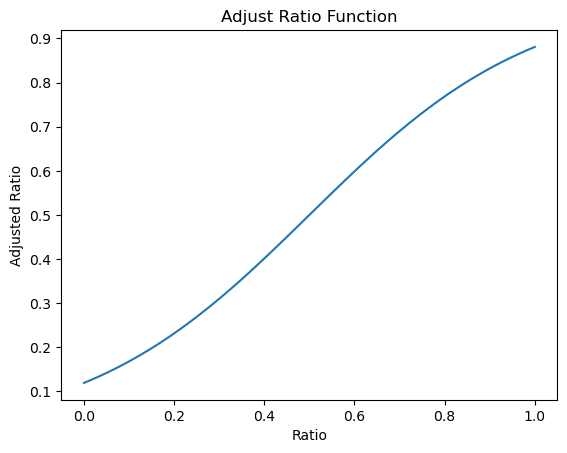

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def adjust_ratio(ratio):
    # 将ratio映射到(-2, 2)区间
    x = 4 * ratio - 2
    # 计算sigmoid函数值
    y = 1 / (1 + np.exp(-x))
    return y

# 生成0到1之间的100个数，作为ratio的值
ratios = np.linspace(0, 1, 100)
# 计算对应的函数值
values = adjust_ratio(ratios)

# 创建一个新的图形
plt.figure()
# 绘制函数图像
plt.plot(ratios, values)
# 设置图形的标题和坐标轴标签
plt.title('Adjust Ratio Function')
plt.xlabel('Ratio')
plt.ylabel('Adjusted Ratio')
# 显示图形
plt.show()
